In [1]:
TRAINING_SET_SIZE = 8
BATCH_SIZE = 512
ROI_SIZE = 64
IMAGE_SIZE = (1450, 1930)
Z_RANGE = 20

In [2]:
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack
    !pip install mat73

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import deeptrack.extras
import tensorflow.keras as keras
import mat73
from matplotlib import colors
from cycler import cycler
from google.colab import drive
from tensorflow.keras import layers, models
from tensorflow.math import abs, angle, real, imag

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

save_model_path = "/content/drive/My Drive/Saved models/"

     |████████████████████████████████| 145 kB 15.4 MB/s 
     |████████████████████████████████| 1.1 MB 34.5 MB/s 
     |████████████████████████████████| 209 kB 38.2 MB/s 
     |████████████████████████████████| 12.5 MB 25.5 MB/s 
     |████████████████████████████████| 109 kB 36.8 MB/s 
     |████████████████████████████████| 51 kB 267 kB/s 
     |████████████████████████████████| 251 kB 40.5 MB/s 
     |████████████████████████████████| 546 kB 22.7 MB/s 
     |████████████████████████████████| 462 kB 37.3 MB/s 
  Created wheel for pydeepimagej: filename=pydeepimagej-2.3.3-py3-none-any.whl size=24230 sha256=1dd5140899caf56f0b9e736de099124757ea6f85d91c22fb61ce2e6b64ff6fcc
  Stored in directory: /root/.cache/pip/wheels/4a/05/98/e4bba4aca59759f5e635d6de7d953a9c60a3db586dd2d96dee
Successfully built pydeepimagej
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3

In [3]:
""" Import experimental data and validation set"""
drive.mount('/content/drive')

# Load a matfile with "downsized" ROI:s around particles found in the experimental data 
filePath = "/content/drive/My Drive/Kandidatarbete/data/isak/traces" + str(ROI_SIZE) + "x" + str(ROI_SIZE) + "ROI.mat"

expData = mat73.loadmat(filePath)
expData = expData['CompletedTraces']

Mounted at /content/drive


In [20]:
""" Store traces of particles and their coordinates"""

# We'll store every found particle's positions during a trace
# in a dictionary with "Particle i" as a key 
particleStr = ["Particle "] * len(expData)
ind = list(range(len(expData)))

particleKey = list(map(lambda l1, l2: l1 + str(l2), particleStr, ind))
posVal = []

for i in range(len(expData)):
    posData = expData[i]['Positions']
    # Cut away unneccessary columns and adjust offset to actual frame 
    posData = posData[:, 0:4]
    posData[:, 0] -= 203
    posVal.append(posData)

posDict = dict(zip(particleKey, posVal))

# We'll create another dictionary storing the particles' ROI's
roiVal = []

for i in range(len(expData)):
    roiData = expData[i]['ROI'][0]
    roiVal.append(roiData)

roiDict = dict(zip(particleKey, roiVal))

[ 1.         -0.22272769  1.52899452  0.90833333 -0.27777538  0.05894492
  0.0243902 ]
[ 1.          0.16003357  1.17433467 -0.92583333  0.10565198 -0.02691686
  0.0243902 ]
[ 2.         -0.2032141   3.24507414  0.45833333 -0.29938298 -0.04339972
  0.0487804 ]
[ 1.          0.16316733  1.86007076 -0.02166667  1.09575747 -0.11607917
  0.0243902 ]
[ 1.          0.69756133  2.6007936   0.81083333  0.80383105 -0.0883305
  0.0243902 ]
[ 1.          0.27833653  1.22306633 -0.44416667  1.00654535 -0.04698
  0.0243902 ]
[ 2.          0.2166708   2.50613661 -0.99666667  0.29105795  0.0306757
  0.0487804 ]
[ 2.         -0.46186623  2.94374231 -0.435       0.15270479 -0.00489767
  0.0487804 ]
[ 1.         -0.13954609  1.11771477  0.16833333 -0.65159463  0.02422226
  0.0243902 ]
[ 1.          0.24844209  2.4056929  -0.08416667 -0.58489227  0.05549549
  0.0243902 ]
[ 1.         -0.23535063  1.30522677 -0.30666667 -0.34380939 -0.13209549
  0.0243902 ]
[ 1.         -0.5641468   2.14579536  0.10666667

In [ ]:
# """Remove one entry in both dictionaries and used to validate models on"""
# validation_fields = roiDict["Particle " + str(len(expData) - 1)]
# roiDict.pop("Particle " + str(len(expData) - 1))
# validation_pos = posDict["Particle " + str(len(expData) - 1)]
# posDict.pop("Particle " + str(len(expData) - 1))

In [5]:
""" Function to import used to unpack rows of FFT-field"""
def exp_expand(data,shape):
    x = np.arange(shape[0]) - shape[0] / 2
    y = np.arange(shape[1]) - shape[1] / 2
    X, Y = np.meshgrid(x, y)
    bg=np.zeros((shape[0]*shape[1],))+0j
    X=np.reshape(np.fft.fftshift(X),(shape[0]*shape[1]))
    Y=np.reshape(np.fft.fftshift(Y),(shape[0]*shape[1]))
    RHO=X**2+Y**2
    Inds=np.argsort(RHO)
    Inds=np.sort(Inds[:data.shape[0]])

    bg[Inds[:data.shape[0]]]=data
    bg=np.reshape(bg,(shape[0],shape[1]))
  
    return bg

In [6]:
""" Function used to divide the whole image into tiles """

def whichTile(cords, IMAGE_SIZE = (1450, 1930), tiles = (3, 3)):

    map = np.reshape(np.arange(0, tiles[0] * tiles[1]), tiles)
    rowSplit = np.cumsum([IMAGE_SIZE[0] // tiles[0] + (1 if x < IMAGE_SIZE[0] % tiles[0] else 0)  for x in range (tiles[0])])
    colSplit = np.cumsum([IMAGE_SIZE[1] // tiles[1] + (1 if x < IMAGE_SIZE[1] % tiles[1] else 0)  for x in range (tiles[1])])

    rowSeg = sum(rowSplit < cords[1])
    colSeg = sum(colSplit < cords[0])

    return map[rowSeg, colSeg]

# We'll now store ROI's belong to each tile in a dictionary with the tile number 
# as a key
no_tiles = 9
dictLabels = ["Tile "] * no_tiles
ind = list(range(no_tiles))
dictKey = list(map(lambda l1, l2: l1 + str(l2), dictLabels, ind))
tileDict = dict(zip(dictKey, [None]*len(dictKey)))


for particle, M in posDict.items():

    for ind, row in enumerate(M):
        tile = whichTile((row[1]/0.115, row[2]/0.115))
        if tileDict["Tile " + str(tile)] == None:
            tileDict["Tile " + str(tile)] = []
            tileDict["Tile " + str(tile)].append(roiDict[particle][ind, :])
            break
        tileDict["Tile " + str(tile)].append(roiDict[particle][ind, :])


In [7]:
"""Create group/equivariance"""

crop_size = 64
padding = 32
wavelength = 525e-9
pixel_size = 115e-9 
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

args = dt.Arguments(
    translate=lambda: np.random.randn(2)*1,
    rotate=lambda: np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randn(1)*20,
)

group = ( 
    dt.Affine(rotate=args.rotate) 
    >> dt.Affine(translate=args.translate) 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.00)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
)

equivariance = (
    dt.models.lodestar.Rotational2DEquivariance(args.rotate)
    >> dt.models.lodestar.TranslationalEquivariance(args.translate)
    >> dt.models.lodestar.Equivariance(-1, args.z / 10, indexes=2)
)

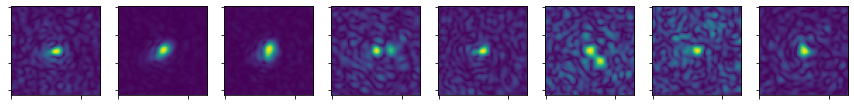

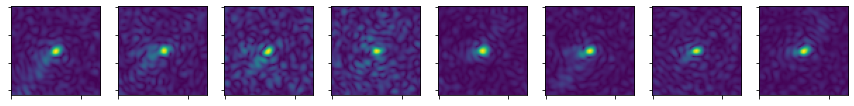

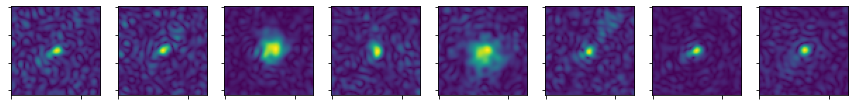

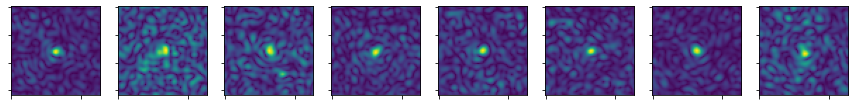

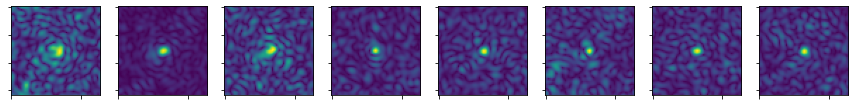

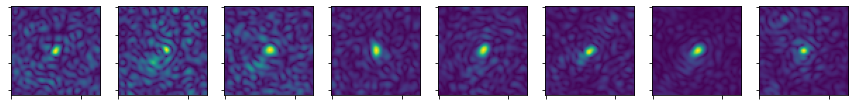

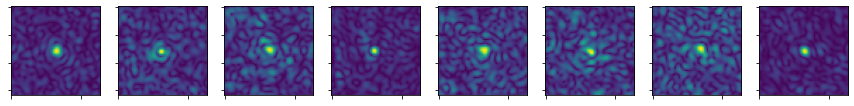

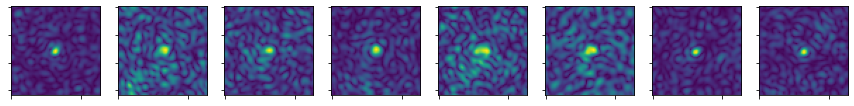

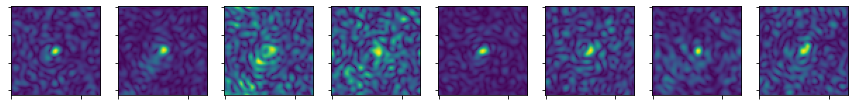

In [ ]:
""" Create training sets to be used in the generators"""

training_sets = [None] * no_tiles
import random
for i in range(no_tiles):
  train_ims = []
  fig, axes = plt.subplots(1, TRAINING_SET_SIZE, figsize = (15, 8))
  for j in range(TRAINING_SET_SIZE):
    im = random.choice(tileDict["Tile " + str(i)])
    im = np.fft.ifft2(exp_expand(im, [ROI_SIZE, ROI_SIZE]))
    im = np.fft.fftshift(im)

    # Plot images used in training
    axes[j].imshow(abs(im))
    axes[j].xaxis.set_ticklabels([])
    axes[j].yaxis.set_ticklabels([])

    im = np.stack((np.real(im), np.imag(im)), axis = -1)
    train_ims.append(im)

    
  ims_as_features = dt.Value(lambda: random.choice(train_ims))
  x = (ims_as_features >> group).update()()  
  training_sets[i] = ims_as_features



In [8]:
"""Create custom layers"""
from tensorflow.math import abs, angle, real, imag, subtract, multiply

class CustomLayerOne(keras.layers.Layer):
    "Dpes nothing"
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), angle(image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerTwo(keras.layers.Layer):
    "Takes 2 layers as input and outputs 3 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([real(norm_image), imag(norm_image), abs(norm_image)], axis=-1)#tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

class CustomLayerThree(keras.layers.Layer):
    "Takes 2 layers as input and outputs 4 layers."
    def __init__(self):
        super().__init__()

    def build( self, input_shape):
        super().build(input_shape)

    def call(self, image):
        image = tf.dtypes.complex(image[...,0], image[...,1])
        norm_image = subtract(image, 1)
        return tf.stack([abs(norm_image), angle(image), real(norm_image), imag(norm_image)], axis=-1)

        

In [9]:
"""Create models"""
num_outputs = 3

def create_model(custom_layer, nlayers):
    model = keras.models.Sequential()
    model.add(keras.Input(shape=(ROI_SIZE,ROI_SIZE,2)))
    model.add(custom_layer)
    model.add(keras.layers.Conv2D(32, 3, activation='relu', strides=(2,2)))
    for _ in range(nlayers):
        model.add(keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(keras.layers.Conv2D(num_outputs+1,1))
    model = dt.models.LodeSTAR(model=model, input_shape=(None, None, 2), num_outputs=num_outputs)
    model.specs = {"Layers": nlayers}
    model.totalhistory = {"total_loss":[], "consistency_loss":[]}
    model.compile(loss=["mae", "mae", "mae"], optimizer=tf.keras.optimizers.Adam(), loss_weights=[1, 1, 1])
    return model



In [ ]:
# We'll initiate one model for every tile in the original image
list_of_models = []
for _ in range(no_tiles):
  list_of_models.append(create_model(CustomLayerThree(), 3))

In [10]:
""" Save and load methods """
# We'll only save the weights and then initialize new models with known weights when loading

def save_models(model_list):
  for i, model in enumerate(model_list):
    model.save_weights(save_model_path + f"model{i}")

def load_models(path, no_models):
  model_list = []
  for i in range(no_models):
    model = create_model(CustomLayerThree(), 3)
    model.load_weights(path + f"model{i}")
    model_list.append(model)

  return model_list


In [11]:
list_of_models = load_models(save_model_path, 9)

In [ ]:
"""Helper functions to plot results"""

def save_progress(model, h):
    model.totalhistory["total_loss"].extend(h.history["total_loss"])
    model.totalhistory["consistency_loss"].extend(h.history["consistency_loss"])

def plot_progress(model, tile):
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w

    cc = (cycler(color=list('bgrcmyk')))
    titleStr = "Model for tile " + str(ind)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(25,6))
    ax1.set_prop_cycle(cc)
    ax2.set_prop_cycle(cc)

    ax1.plot(moving_average(model.totalhistory["total_loss"], 10), label=f"{model.specs}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Total Loss")
    ax1.set_yscale("log")
    ax1.legend()
    ax1.set_title(titleStr)

    ax2.plot(moving_average(model.totalhistory["consistency_loss"], 10), label=f"{model.specs}")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Consistency loss")
    ax2.set_yscale("log")
    ax2.legend()
    ax2.set_title(titleStr)

    ax1.grid(True)
    ax2.grid(True)
    plt.show()

In [ ]:
"""Create generators"""

list_of_generators = []

for i in range(no_tiles):
  generator = dt.models.lodestar.LodeSTARGenerator(
      training_sets[i],
      num_outputs=num_outputs, 
      transformation_function=(group, equivariance), 
      batch_size=8, 
      min_data_size=200, 
      max_data_size=201,
  )
  list_of_generators.append(generator)

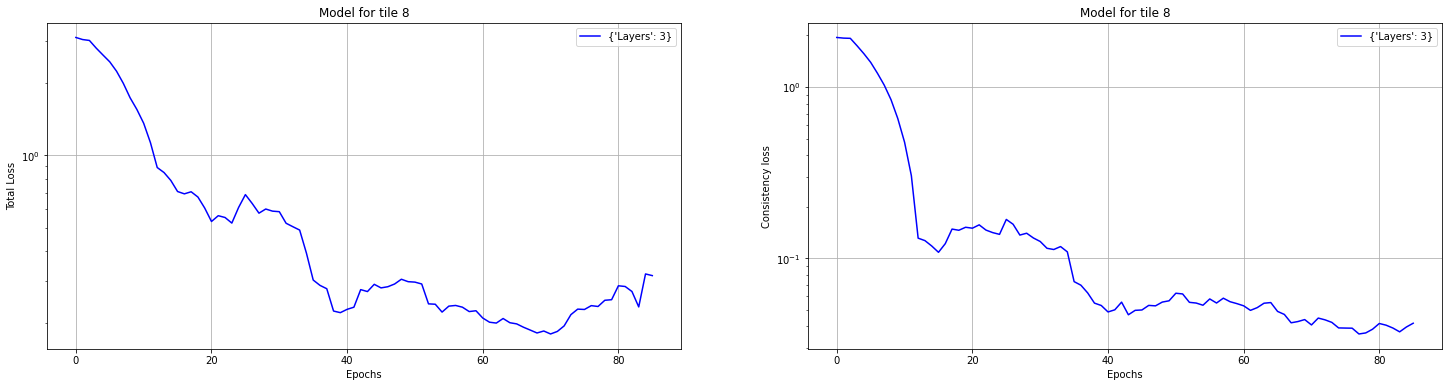

Training done!


In [ ]:
""" Loop through all nine models train network"""
from IPython.display import clear_output

for ind, generator in enumerate(list_of_generators):
  model = list_of_models[ind]
  for _ in range(1, 20):
    with generator:
      h = model.fit(generator, epochs = 5, steps_per_epoch = 100, verbose = 0)
      save_progress(model, h)
    clear_output(wait = True)
    plot_progress(model, ind)
    

  list_of_models[ind] = model
print("Training done!")

In [ ]:
""" Save trained models"""
save_models(list_of_models)

In [ ]:
"""Load trained models"""
list_of_models = load_models(save_model_path, 9)

In [12]:
"""Method to calculate sigma"""

def calc_sigma(diffusion, frame_nos):

    # Compensate for potential loss of a frame in the trace
    dt = np.diff(frame_nos)
    v_diff = np.diff(diffusion)
    v_diff = v_diff / np.sqrt(dt)

    sigma2 = np.abs(np.mean(
        np.multiply(
            np.diff(v_diff[:-1]), 
            np.diff(v_diff[1:])
            )
    ))
    return np.sqrt(sigma2)

In [49]:
"""Predictions"""
import random
def detect_on_trace(position_m, roi_m):

  trace = []
  tile_list = []
  for posRow, roiRow in zip(posM, roiM):
    tile_list.append(whichTile((posRow[1] / 0.115, posRow[2] / 0.115)))

    # Unpack field
    frame = np.fft.ifft2(exp_expand(roiRow, [ROI_SIZE, ROI_SIZE]))
    frame = np.fft.fftshift(frame)
    frame = np.expand_dims(frame, axis = -1)
    trace.append(frame)

  # # Save 9 frames to get a feel of how the trace looks
  # frames =  []
  # for i in range(4):
  #   frames.append(np.squeeze(random.choice(trace)))
  # tile_of_frames = np.concatenate((np.concatenate((np.array(frames[0]), np.array(frames[1]))), \
  #                         np.concatenate((np.array(frames[2]), np.array(frames[3])))), axis = -1)

  trace = np.array(trace)
  val_stack = np.stack((np.real(trace[..., 0]), np.imag(trace[..., 0])), axis = -1)
  dets = []
  for tile, im in zip(tile_list, val_stack):
    im = np.expand_dims(im, axis = 0)
    dets.append(np.array(list_of_models[tile].predict_and_detect(im, mode = "ratio")))

  return dets

corrected_z_trace = []
corrected_x_trace = []
# Loop through all particles found in video
for posM, roiM in zip(posDict.values(), roiDict.values()):
  dets = detect_on_trace(posM, roiM)

  x_network = []
  y_network = []
  z_network = []

  for row in dets:
    x_network.append(row[0][0][0])
    y_network.append(row[0][0][1])
    z_network.append(row[0][0][2])

  x_network = np.array(x_network)
  y_network = np.array(y_network)
  z_network = np.array(z_network)


  frame_no = np.array(posM[:, 0])
  x_matlab = np.array(posM[:, 1])
  y_matlab = np.array(posM[:, 2])
  z_matlab = np.array(posM[:, 3])

  data = [x_matlab, y_matlab, z_matlab]
  z_network = z_network / -10
  z_network = z_network - np.mean(z_network)

  cor_data = [x_matlab - (32 - x_network)* 0.115, y_matlab - (32 - y_network) * 0.115, z_matlab - z_network]
  label = ["x", "y", "z"]
  # fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (15, 6))

  sigma_matlab = calc_sigma(z_matlab, frame_no)
  sigma_cor = calc_sigma(cor_data[2], frame_no)

  corrected_z_trace.append(cor_data[2])
  corrected_x_trace.append(cor_data[0])

  # for ind, ax in enumerate(axes):
  #   if ind == 3:
  #     ax.imshow(abs(frames))
  #     ax.set_title("Example of how the trace looks")
  #     break
  #   ax.plot(frame_no, data[ind], 'b')
  #   ax.plot(frame_no, cor_data[ind], 'r')
  #   ax.set_xlabel(label[ind])
  #   ax.set_ylabel("Diffusion")
  
  # print(f"Matlab sigma: {sigma_matlab}    " + f"Korr. sigma: {sigma_cor}")

In [50]:
"""Functions to calculate diffusion"""

# def get_msd(x, max_dt=4):

#     output = []
#     for delt in range(max_dt):
#         delta_x = x[1 + delt :] - x[: -(1 + delt)]
        
#         th = 100 * np.sqrt(delt + 1)
#         if np.any(delta_x > th):
#             print(np.sum(delta_x > th))

#         delta_x[delta_x > th] = 0
#         squared_displacement = np.square(delta_x).sum(axis=-1)

#         # superful fix här, för att den ska fungera för ensamma traces :----)
#         if type(squared_displacement) == np.float32 or type(squared_displacement) == np.float64:
#           length = 1
#         else:
#           length = len(squared_displacement)
#         output.append(
#             (
#                 np.mean(squared_displacement),
#                 np.std(squared_displacement),
#                 length,
#             )
#         )

#     return np.array(output)
def get_msd(x, max_dt=4):

    output = []
    for delt in range(max_dt):
        delta = x[1 + delt :] - x[: -(1 + delt)]
        
        th = 100 * np.sqrt(delt + 1)
        if np.any(delta > th):
            print(np.sum(delta > th))

        delta[delta > th] = 0
        squared_displacement = np.square(delta)

        output.append(
            (
                np.mean(squared_displacement),
                np.std(squared_displacement),
                len(squared_displacement),
            )
        )

    return np.array(output)

def fit_to_line(msd):
    return np.polyfit(range(1, msd.shape[0]+1), msd[:, 0], 1)

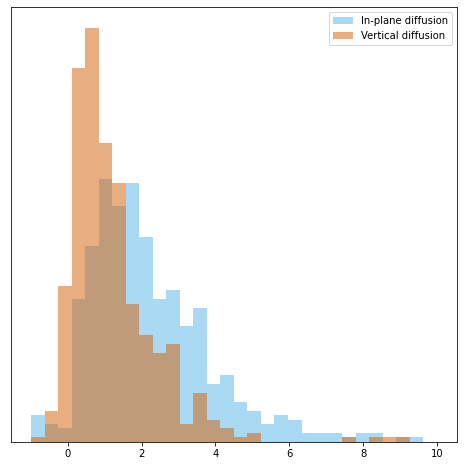

In [51]:
' DIFFUSION CALCULATIONS'
"""
  TODO:
    - make all_positions include all traces
"""
import seaborn
delta_time = 0.0243902 # From experimental data
msds = []
msds_z = []

for x_trace, z_trace in zip(corrected_x_trace, corrected_z_trace):
    msd = get_msd(x_trace, 10) 
    a, b = fit_to_line(msd[:4])
    msds.append(a)

    msd_z = get_msd(z_trace, 10)
    a, b = fit_to_line(msd_z[:4])
    msds_z.append(a)


plt.figure(figsize=(8, 8))
plt.hist(np.array(msds) / delta_time / 2, 30, alpha=0.5, range=(-1, 10), facecolor=seaborn.color_palette("colorblind")[9], label="In-plane diffusion")
plt.hist(np.array(msds_z) / delta_time / 2, 30, alpha=0.5, range=(-1, 10), facecolor=seaborn.color_palette("colorblind")[3], label="Vertical diffusion")
plt.yticks([])
plt.legend()